In [41]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema as extre
from scipy.optimize import curve_fit as fit

def gauss(x, a, mu, sigma):
    return a*np.exp(-(x-mu)**2/(2.*sigma**2))

In [81]:
import os

def loaddata(rootpath, isex=True):
    data = {}
    for path in os.listdir(rootpath):
        if path.startswith('.'): 
            continue
        subpath = rootpath+'/'+path+'/'
        file = [i for i in os.listdir(subpath) if i.endswith('txt')]
        
        # load data, and divide by livetime if it is from experiments
        if isex:
            data[path[:3]] = {i[:-8] : np.genfromtxt(subpath+i,delimiter=' ')[:,1]/int(i[-7:-4]) for i in file}
        else:
            data[path[:3]] = {i[:-4] : np.genfromtxt(subpath+i,delimiter=' ')[:,1] for i in file}
    return data

ex = loaddata('./20201021')
mc = loaddata('./20201021MC', isex = False)

In [82]:
channel = np.array(range(512))

In [83]:
def smooth(series,strength=3):
    return np.convolve(series, np.ones(2*strength+1)/(2*strength+1), mode='same' )

In [88]:
def exbkg(data):
    lvc = extre(smooth(data), np.less, order = 20,mode = 'wrap')[0][0] #左边界
    pkc = extre(data[50:], np.greater, order = 60,mode='wrap')[0][-1] + 50
    rvc = min(2*pkc-lvc,511) #右边界

    lvh = np.average(data[lvc-3:lvc+4])
    rvh = np.average(data[rvc-3:rvc+4])
    delta_rl= lvh-rvh
    sum_rl = np.sum(data[lvc:rvc+1])

    bkg = np.array([np.sum(data[lvc+i:rvc+1])/sum_rl*delta_rl + rvh for i in range(rvc+1-lvc)])
    sig = data[lvc:rvc+1] - bkg
    sig = np.concatenate((np.zeros(lvc),sig,np.zeros(511-rvc)))
    
    return sig, lvc, pkc, rvc

In [89]:
def findpeak(data):
    sig, lvc, pkc, rvc = exbkg(data)
    p0= np.array([0,0,0])
    p = np.array([sig[pkc], pkc, (rvc-lvc)/2]) # a, mu, sigma
    var = np.array([0,0,0])
    
    win = channel[np.logical_and(p[1]-p[2]-1<channel,channel<p[1]+p[2]+1)] # window

    while np.any(np.absolute(p-p0) > 0):
        p0 = p 
        popt, pcov = fit(gauss,win,sig[win], p0=p0)
        p = np.absolute(popt)
        var = np.array([np.sqrt(pcov[i,i]) for i in range(3)])
        win = channel[np.logical_and(p[1]-p[2]-1<channel,channel<p[1]+p[2]+1)] # window
        
    return popt, var 

In [92]:
for name, data in ex['Vac'].items():
    popt, var = findpeak(data)
    print(popt)
    #     print(data)
#     print(ex['Vac'].keys())
vacpeak = [findpeak(data) for data in ex['Vac'].values()]
    

[ 3.99371966 95.19127649 11.9055717 ]
[  6.34580598 152.46358093  12.26670308]
[  6.43724556 212.87922113  13.16515847]
[  5.22678139 264.99049351  14.20159116]
[  3.37128857 322.38889953  15.43195859]
[  1.4781403  380.43187826  16.53054708]
[3.16217662e-01 4.36813339e+02 1.69722713e+01]


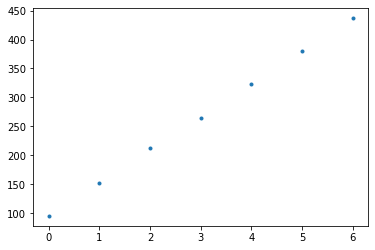

In [96]:
fig = plt.figure()
axi = fig.add_subplot(111)

# for name, data in ex['Air'].items():
#     axi.plot(channel,smooth(data,2))
# axi.plot(channel[lvc:rvc+1],sig, '.', markersize=1)
# axi.plot(channel[lvc:rvc+1],bkg, '.', markersize=1)

axi.plot(range(7),[i[0][1]for i in vacpeak],'.')

plt.show()

In [7]:
# lwin = channel[np.logical_and(mu-1.5*sigma<channel,channel<mu-0.8*sigma)]   
# rwin = channel[np.logical_and(mu+0.8*sigma<channel,channel<mu+1.5*sigma)]
# lp = np.polyfit(lwin, sig[lwin-lvc], 5)
# rp = np.polyfit(rwin, sig[rwin-lvc], 5)
# axi.plot(lwin,np.poly1d(lp)(lwin))
# axi.plot(rwin,np.poly1d(rp)(rwin))
